In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
import joblib
from joblib import parallel_backend

In [3]:
df1 = pd.read_csv("DATA/train.csv")

In [4]:
df2 = pd.read_csv("DATA/training_extra.csv")

In [5]:
df = pd.concat([df1, df2], ignore_index=True)

In [6]:
len(df1) / (len(df1) + len(df2))

0.07510668905179808

In [7]:
len(df1)

300000

In [8]:
len(df)

3994318

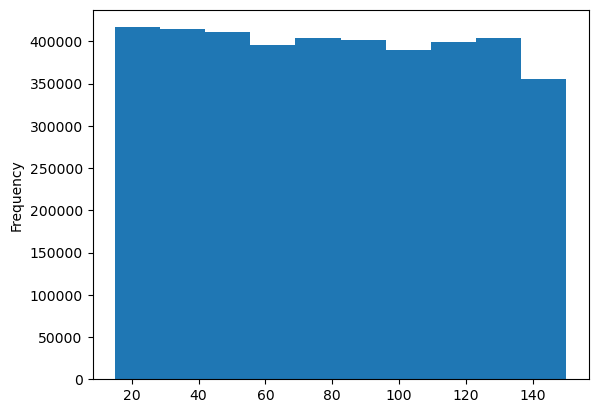

In [9]:
df.Price.plot(kind='hist');

In [10]:
df.dtypes

id                        int64
Brand                    object
Material                 object
Size                     object
Compartments            float64
Laptop Compartment       object
Waterproof               object
Style                    object
Color                    object
Weight Capacity (kg)    float64
Price                   float64
dtype: object

### Map Binary Columns 
- Laptop Compartment (na=0)
- Waterproof (na=0)

In [11]:
df['Laptop Compartment'] = df['Laptop Compartment'].map({'Yes': 1, 'No': 0}).fillna(0)
df['Waterproof'] = df['Waterproof'].map({'Yes': 1, 'No': 0}).fillna(0)

### Map Size Column
- Small: 1
- Medium: 2
- Large: 3
- na: 2

In [12]:
df['Size'] = df['Size'].map({'Small': 1, 'Medium': 2, 'Large': 3}).fillna(2)

### Numeric Columns
Fill null values with median

In [13]:
df['Compartments'] = df['Compartments'].fillna(df['Compartments'].median())
df['Weight Capacity (kg)'] = df['Weight Capacity (kg)'].fillna(df['Weight Capacity (kg)'].median())

### Categorical Columns
Convert object dtypes to categorical

In [14]:
df[['Brand', 'Material', 'Style', 'Color']] = df[['Brand', 'Material', 'Style', 'Color']].astype('category')

### Split Data

In [15]:
X = df.drop(columns=['Price', 'id'])
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [16]:
model = XGBRegressor(
    enable_categorical=True,
    n_jobs=-1
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [17]:
predictions = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(rmse)

38.8804265820533


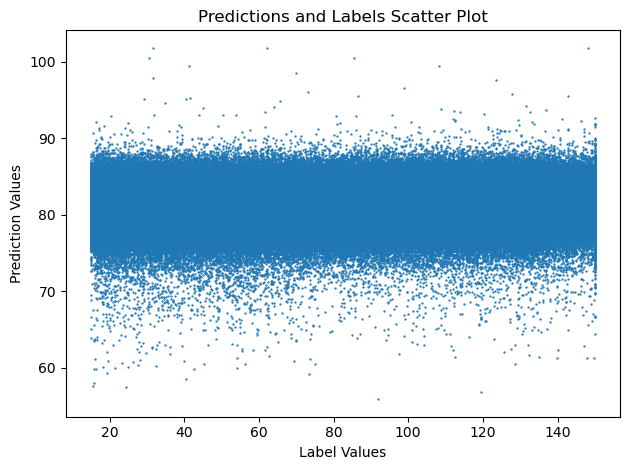

In [20]:
plt.scatter(y_test, predictions, s=0.4)
plt.title('Predictions and Labels Scatter Plot')
plt.xlabel('Label Values')
plt.ylabel('Prediction Values')
plt.tight_layout()
plt.savefig('predictions_scatter.png')

### Grid Search CV

In [64]:
# RMSE scorer
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

# Initialize model
xgb_model = XGBRegressor(enable_categorical=True, n_jobs=-1)

# Search grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.2]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_grid, 
    cv=5, 
    scoring=rmse_scorer, 
    verbose=2,
)

In [65]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   5.8s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   5.8s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   5.8s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   5.9s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   5.8s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   9.8s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   9.9s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   9.8s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   9.8s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   9.6s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=  17.3s
[CV] END ...learning_rate=0.1, max_depth=3, n_es

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=True, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, ma...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=-1, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.2], 'max_depth': [3, 6, 9],
                         'n_estimators': [50, 100, 200]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False),
             verbose=2)

In [39]:
### Previously ran successfully when gridsearch was trained and initialized
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

NameError: name 'grid_search' is not defined

In [31]:
best_params = {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}

Best parameters found:  {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}

In [32]:
best_params['enable_categorical'] = True
best_params['n_jobs'] = -1
final_model = XGBRegressor(**best_params)
final_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [33]:
predictions = final_model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print("Root Mean Squared Error: ", rmse)

Root Mean Squared Error:  38.86743491701613


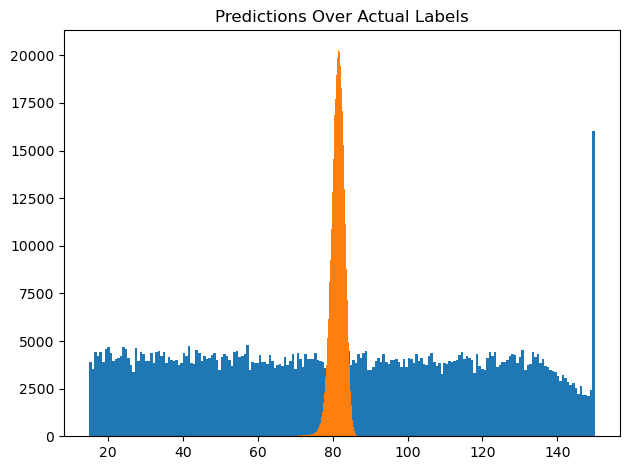

In [36]:
plt.hist(y_test, bins=200)
plt.hist(predictions, bins=200);
plt.title('Predictions Over Actual Labels')
plt.tight_layout()
plt.savefig('predictions_hist.png')

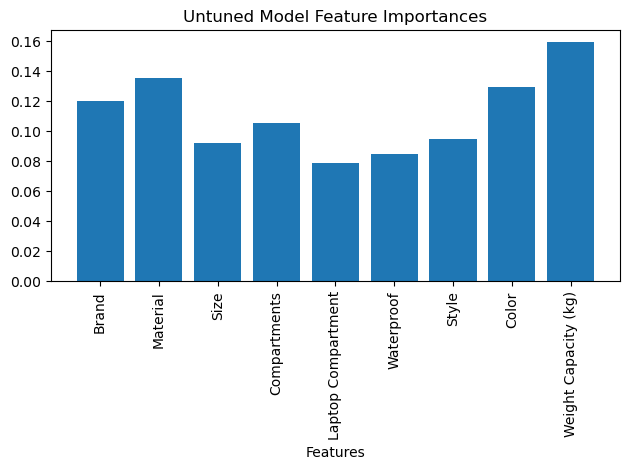

In [37]:
feature_importances = model.feature_importances_
plt.bar(X_train.columns, height=feature_importances)
plt.xticks(rotation=90);
plt.title('Untuned Model Feature Importances')
plt.xlabel('Features')
plt.tight_layout()
plt.savefig('features_untuned.png')

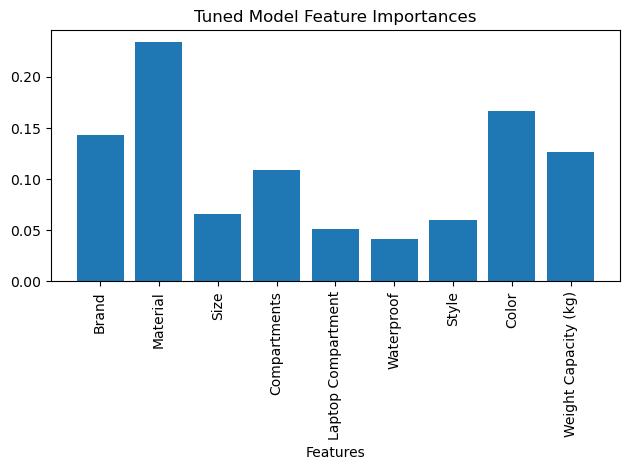

In [38]:
feature_importances = final_model.feature_importances_
plt.bar(X_train.columns, height=feature_importances)
plt.xticks(rotation=90);
plt.title('Tuned Model Feature Importances')
plt.xlabel('Features')
plt.tight_layout()
plt.savefig('features_tuned.png')